In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combi = pd.concat([train.drop('target', axis=1), test], axis=0)

In [3]:
# Too much data for my computer, so we'll take a sample
train = train.sample(frac=1.0)
train_sample = train.sample(40000)

train_sample = train_sample.head(30000)
test = train_sample.tail(10000)

x = train_sample.drop('target', axis=1)
y = train_sample['target']

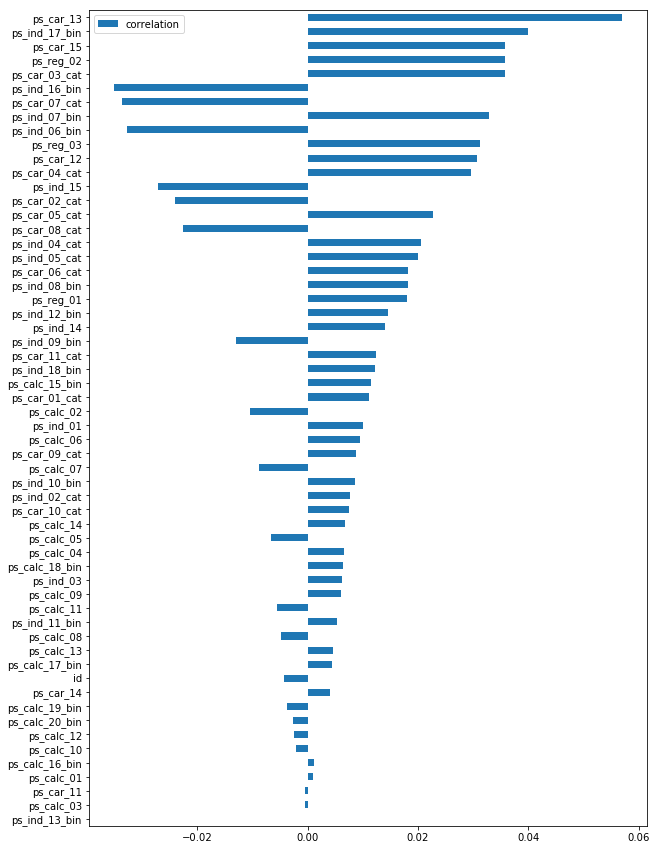

In [4]:
def absolute_correlations(col, df=train_sample, ascending=False):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    corrs.dropna(inplace=True)
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    elif ascending == True:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)    
    
absolute_correlations('target', ascending=True).plot.barh(figsize=(10,15))

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(n_splits=3, shuffle=True)

clf = XGBClassifier()
params = {'max_depth': [2],
         'n_estimators': np.arange(90,101,10),
         'reg_lambda': np.arange(1.2, 1.51, .1)}

grid = GridSearchCV(clf, param_grid=params, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=0,
       silent=True, subsample=1) 

Mean score: 0.614851620355
Std Dev:    0.00287137282746


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

log = Pipeline([
    ('scale', RobustScaler()),
    ('regress', LogisticRegression())
])

params = {
    'scale__quantile_range': [(40,60), (30,70), (20,80), (10,90), (5,95), (1,99)],
    'regress__C': np.arange(.8,1.61,.1,)
}

grid = GridSearchCV(log, param_grid=params, cv=kf, scoring='r2').fit(x, y)
log = grid.best_estimator_
print(log, '\n')

cv = cross_val_score(log, x, y, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)), ('regress', LogisticRegression(C=0.80000000000000004, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]) 

Mean score: 0.60616394607
Std Dev:    0.0127971196411


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
xg = Pipeline([
    ('scale', RobustScaler()),
    ('classify', XGBClassifier())
])

params = {
    'scale__quantile_range': [(40,60), (30,70)],
    'classify__n_estimators': np.arange(100,116,5),
    'classify__max_depth': [2,3],
    'classify__reg_lambda': np.arange(1.1, 1.31, .1)
}

grid = GridSearchCV(xg, param_grid=params, cv=kf, scoring='r2').fit(x, y)
xg = grid.best_estimator_
print(xg, '\n')

cv = cross_val_score(xg, x, y, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)), ('classify', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_...pha=0, reg_lambda=1.1000000000000001, scale_pos_weight=1,
       seed=0, silent=True, subsample=1))]) 

Mean score: 0.616839095256
Std Dev:    0.0107172559266


In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada = Pipeline([
    ('scale', RobustScaler()),
    ('classify', AdaBoostClassifier())
])

params = {
    'scale__quantile_range': [(40,60), (30,70), (20,80), (10,90), (5,95), (1,99)],
    'classify__n_estimators': np.arange(100,116,5),
    'classify__learning_rate': [.1, 1],
}

grid = GridSearchCV(ada, param_grid=params, cv=kf, scoring='r2').fit(x, y)
ada = grid.best_estimator_
print(ada, '\n')

cv = cross_val_score(ada, x, y, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None))]) 

Mean score: 0.61053149959
Std Dev:    0.00252585548931


In [9]:
from sklearn.svm import LinearSVC

svc = Pipeline([
    ('scale', RobustScaler()),
    ('classify', LinearSVC())
])

params = {
    'scale__quantile_range': [(40,60), (30,70), (20, 80)],
    'classify__C': [.01, .1,],
    'classify__loss': ['squared_hinge'],
}

grid = GridSearchCV(svc, param_grid=params, cv=kf, scoring='roc_auc').fit(x, y)
svc = grid.best_estimator_
print(svc, '\n')

cv = cross_val_score(svc, x, y, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(20, 80), with_centering=True,
       with_scaling=True)), ('classify', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]) 

Mean score: 0.601290965866
Std Dev:    0.0142801196153


In [10]:
# Not currently working

from mlxtend.classifier import StackingClassifier
from itertools import combinations

clfs = [log, svc, xg, ada]
clf_combinations =\
[list(i) for i in combinations(clfs, 2)]

clf = StackingClassifier(classifiers=[log, xg], meta_classifier=log)
params = {'classifiers': [log, svc],
          'meta_classifier': [xg],#clf_combinations,
         }

grid = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Vince\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Vince\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001E86DBA4810, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\V...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001E86DBA4810, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\V...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-15T22:07:39.263976', 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'session': 'D349454A0B3648988FF05E6C1787378E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'D349454A0B3648988FF05E6C1787378E']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-15T22:07:39.263976', 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'session': 'D349454A0B3648988FF05E6C1787378E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'D349454A0B3648988FF05E6C1787378E'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-15T22:07:39.263976', 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'session': 'D349454A0B3648988FF05E6C1787378E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '93E03FBA721B45A99D7DF9FA3124359B', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from mlxtend.classifier import StackingClassifie...s, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)\n", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-10-916e82dde7d7>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1e87fbb40b8, executio..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001E8134B5A50, file "<ipython-input-10-916e82dde7d7>", line 12>
        result = <ExecutionResult object at 1e87fbb40b8, executio..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001E8134B5A50, file "<ipython-input-10-916e82dde7d7>", line 12>, result=<ExecutionResult object at 1e87fbb40b8, executio..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001E8134B5A50, file "<ipython-input-10-916e82dde7d7>", line 12>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\Vince\Google Drive\Cloud Storage\Cloud\Safe Drivers\<ipython-input-10-916e82dde7d7> in <module>()
      7 clf = StackingClassifier(classifiers=[log, xg], meta_classifier=log)
      8 params = {'classifiers': [log, svc],
      9           'meta_classifier': [xg],#clf_combinations,
     10          }
     11 
---> 12 grid = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=0), X=             id  ps_ind_01  ps_ind_02_cat  ps_in...   1               0  

[30000 rows x 58 columns], y=358177    0
50636     0
269464    0
250465    0
...19    0
Name: target, Length: 30000, dtype: int64, groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =              id  ps_ind_01  ps_ind_02_cat  ps_in...   1               0  

[30000 rows x 58 columns]
        y = 358177    0
50636     0
269464    0
250465    0
...19    0
Name: target, Length: 30000, dtype: int64
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Dec 15 22:07:43 2017
PID: 18892                Python 3.6.0: C:\Users\Vince\Anaconda3\python.exe
...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0),              id  ps_ind_01  ps_ind_02_cat  ps_in...   1               0  

[30000 rows x 58 columns], 358177    0
50636     0
269464    0
250465    0
...19    0
Name: target, Length: 30000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 9325,  9349,  9351, ..., 29997, 29998, 29999]), array([    0,     1,     2, ..., 10027, 10028, 10029]), 0, {'classifiers': Pipeline(memory=None,
     steps=[('scale', Robu...ear', tol=0.0001, verbose=0, warm_start=False))]), 'meta_classifier': Pipeline(memory=None,
     steps=[('scale', Robu...ht=1,
       seed=0, silent=True, subsample=1))])}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0),              id  ps_ind_01  ps_ind_02_cat  ps_in...   1               0  

[30000 rows x 58 columns], 358177    0
50636     0
269464    0
250465    0
...19    0
Name: target, Length: 30000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 9325,  9349,  9351, ..., 29997, 29998, 29999]), array([    0,     1,     2, ..., 10027, 10028, 10029]), 0, {'classifiers': Pipeline(memory=None,
     steps=[('scale', Robu...ear', tol=0.0001, verbose=0, warm_start=False))]), 'meta_classifier': Pipeline(memory=None,
     steps=[('scale', Robu...ht=1,
       seed=0, silent=True, subsample=1))])})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0), X=             id  ps_ind_01  ps_ind_02_cat  ps_in...   1               0  

[30000 rows x 58 columns], y=358177    0
50636     0
269464    0
250465    0
...19    0
Name: target, Length: 30000, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([ 9325,  9349,  9351, ..., 29997, 29998, 29999]), test=array([    0,     1,     2, ..., 10027, 10028, 10029]), verbose=0, parameters={'classifiers': Pipeline(memory=None,
     steps=[('scale', Robu...ear', tol=0.0001, verbose=0, warm_start=False))]), 'meta_classifier': Pipeline(memory=None,
     steps=[('scale', Robu...ht=1,
       seed=0, silent=True, subsample=1))])}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    418                       for k, v in fit_params.items()])
    419 
    420     test_scores = {}
    421     train_scores = {}
    422     if parameters is not None:
--> 423         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of Stacki...in_secondary=False, use_probas=False, verbose=0)>
        parameters = {'classifiers': Pipeline(memory=None,
     steps=[('scale', Robu...ear', tol=0.0001, verbose=0, warm_start=False))]), 'meta_classifier': Pipeline(memory=None,
     steps=[('scale', Robu...ht=1,
       seed=0, silent=True, subsample=1))])}
    424 
    425     start_time = time.time()
    426 
    427     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\base.py in set_params(self=StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0), **params={'classifiers': Pipeline(memory=None,
     steps=[('scale', Robu...ear', tol=0.0001, verbose=0, warm_start=False))]), 'meta_classifier': Pipeline(memory=None,
     steps=[('scale', Robu...ht=1,
       seed=0, silent=True, subsample=1))])})
    278                 # simple objects case
    279                 if key not in valid_params:
    280                     raise ValueError('Invalid parameter %s for estimator %s. '
    281                                      'Check the list of available parameters '
    282                                      'with `estimator.get_params().keys()`.' %
--> 283                                      (key, self.__class__.__name__))
        key = 'classifiers'
        self.__class__.__name__ = 'StackingClassifier'
    284                 setattr(self, key, value)
    285         return self
    286 
    287     def __repr__(self):

ValueError: Invalid parameter classifiers for estimator StackingClassifier. Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [17]:
# clf = grid.best_estimator_

# print(clf, '\n')
clf = StackingClassifier(classifiers=[xg, ada], meta_classifier=xg)

cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.5
Std Dev:    0.0


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, x, y, 
                                              cv=3, scoring='roc_auc')
    print("ROC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

ROC: 0.51 (+/- 0.01) [KNN]
ROC: 0.54 (+/- 0.03) [Random Forest]
ROC: 0.54 (+/- 0.00) [Naive Bayes]
ROC: 0.50 (+/- 0.01) [StackingClassifier]


In [37]:
from mlxtend.classifier import StackingClassifier
from itertools import combinations

clfs = [lr, clf1, clf2, clf3]
clf_combinations =\
[list(i) for i in combinations(clfs, 2)]

clf = StackingClassifier(classifiers=[log, xg], meta_classifier=log)
params = {'classifiers': clf_combinations,
          'meta_classifier': [lr],#clf_combinations,
         }

grid = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Vince\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Vince\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000024072BE4810, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\V...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000024072BE4810, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\V...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-03T17:29:20.358375', 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'session': '88CD3B71AC754DA588D78A3B8D54A809', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'88CD3B71AC754DA588D78A3B8D54A809']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-03T17:29:20.358375', 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'session': '88CD3B71AC754DA588D78A3B8D54A809', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'88CD3B71AC754DA588D78A3B8D54A809'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-12-03T17:29:20.358375', 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'session': '88CD3B71AC754DA588D78A3B8D54A809', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F6A405B75A3345AA841E4A144CD61F07', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from mlxtend.classifier import StackingClassifie...ms, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-37-92b9648fa255>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 24024f68c18, executio..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000024007CBE6F0, file "<ipython-input-37-92b9648fa255>", line 12>
        result = <ExecutionResult object at 24024f68c18, executio..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000024007CBE6F0, file "<ipython-input-37-92b9648fa255>", line 12>, result=<ExecutionResult object at 24024f68c18, executio..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000024007CBE6F0, file "<ipython-input-37-92b9648fa255>", line 12>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\Vince\Google Drive\Cloud Storage\Cloud\Safe Drivers\<ipython-input-37-92b9648fa255> in <module>()
      7 clf = StackingClassifier(classifiers=[log, xg], meta_classifier=log)
      8 params = {'classifiers': clf_combinations,
      9           'meta_classifier': [lr],#clf_combinations,
     10          }
     11 
---> 12 grid = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1, scoring='roc_auc').fit(x, y)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=0), X=             id  ps_ind_01  ps_ind_02_cat  ps_in...   0               0  

[10000 rows x 58 columns], y=27014     0
501652    0
533501    0
371464    0
...30    0
Name: target, Length: 10000, dtype: int64, groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =              id  ps_ind_01  ps_ind_02_cat  ps_in...   0               0  

[10000 rows x 58 columns]
        y = 27014     0
501652    0
533501    0
371464    0
...30    0
Name: target, Length: 10000, dtype: int64
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Dec  3 17:29:23 2017
PID: 2584                 Python 3.6.0: C:\Users\Vince\Anaconda3\python.exe
...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0),              id  ps_ind_01  ps_ind_02_cat  ps_in...   0               0  

[10000 rows x 58 columns], 27014     0
501652    0
533501    0
371464    0
...30    0
Name: target, Length: 10000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([3330, 3331, 3332, ..., 9997, 9998, 9999]), array([   0,    1,    2, ..., 3410, 3419, 3458]), 0, {'classifiers': [LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')], 'meta_classifier': LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0),              id  ps_ind_01  ps_ind_02_cat  ps_in...   0               0  

[10000 rows x 58 columns], 27014     0
501652    0
533501    0
371464    0
...30    0
Name: target, Length: 10000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([3330, 3331, 3332, ..., 9997, 9998, 9999]), array([   0,    1,    2, ..., 3410, 3419, 3458]), 0, {'classifiers': [LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')], 'meta_classifier': LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0), X=             id  ps_ind_01  ps_ind_02_cat  ps_in...   0               0  

[10000 rows x 58 columns], y=27014     0
501652    0
533501    0
371464    0
...30    0
Name: target, Length: 10000, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([3330, 3331, 3332, ..., 9997, 9998, 9999]), test=array([   0,    1,    2, ..., 3410, 3419, 3458]), verbose=0, parameters={'classifiers': [LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')], 'meta_classifier': LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    418                       for k, v in fit_params.items()])
    419 
    420     test_scores = {}
    421     train_scores = {}
    422     if parameters is not None:
--> 423         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of Stacki...in_secondary=False, use_probas=False, verbose=0)>
        parameters = {'classifiers': [LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')], 'meta_classifier': LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)}
    424 
    425     start_time = time.time()
    426 
    427     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\Users\Vince\Anaconda3\lib\site-packages\sklearn\base.py in set_params(self=StackingClassifier(average_probas=False,
       ..._in_secondary=False, use_probas=False, verbose=0), **params={'classifiers': [LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')], 'meta_classifier': LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)})
    278                 # simple objects case
    279                 if key not in valid_params:
    280                     raise ValueError('Invalid parameter %s for estimator %s. '
    281                                      'Check the list of available parameters '
    282                                      'with `estimator.get_params().keys()`.' %
--> 283                                      (key, self.__class__.__name__))
        key = 'classifiers'
        self.__class__.__name__ = 'StackingClassifier'
    284                 setattr(self, key, value)
    285         return self
    286 
    287     def __repr__(self):

ValueError: Invalid parameter classifiers for estimator StackingClassifier. Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________